In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as F
import matplotlib.pyplot as plt
import random

In [2]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -other
    
    def __rsub__(self, other):
        return self + -other
    
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(n*2) - 1) / (math.exp(n*2) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [3]:
a = Value(1.0)
b = Value(4.0)
a - b

Value(data=-3.0)

In [4]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp(); e.label = 'e^2x'
o = (e-1) / (e + 1); o.label = 'tanh'


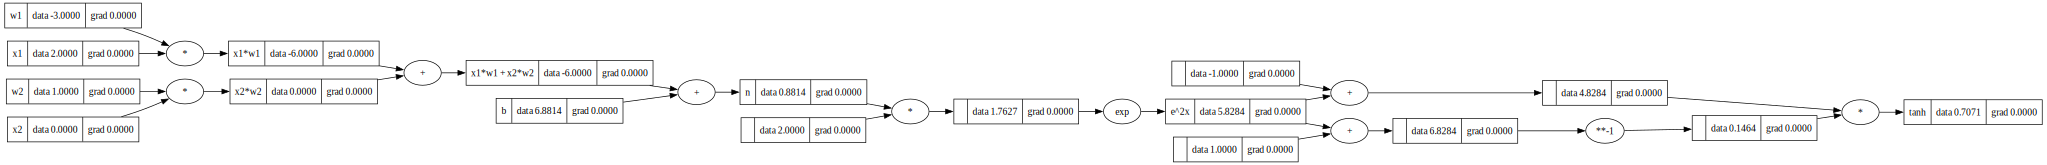

In [6]:
# Draw the computation graph
draw_dot(o)

In [7]:
o.backward()

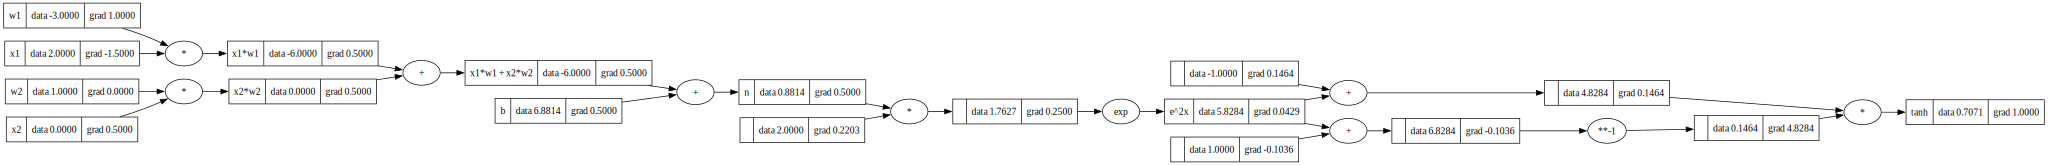

In [8]:
draw_dot(o)

In [9]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # print(self.w, self.b)
        # out = self.w @ x + self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.mlp = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.mlp:
            x = layer(x)
        
        return x

    def parameters(self):
        return [p for layer in self.mlp for p in layer.parameters()]


In [10]:
# draw_dot(mlp(input))

In [11]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [12]:
mlp = MLP(3, [4, 2, 1])

In [13]:
mlp.parameters()[0].grad

0

In [14]:
losses = []

for epoch in range(40):
    # forward pass
    ypred = [mlp(i) for i in xs]
    loss = sum((yp - yt)**2 for yp, yt in zip(ypred, ys))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent update
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    
    losses.append(loss.data)
    print(f"Epoch {epoch}: Loss: {loss.data}")

Epoch 0: Loss: 5.479393986885342
Epoch 1: Loss: 4.128926895778317
Epoch 2: Loss: 3.4293642939166733
Epoch 3: Loss: 3.0231385430067315
Epoch 4: Loss: 2.4082201448058154
Epoch 5: Loss: 1.9021189668389202
Epoch 6: Loss: 1.4986867965165942
Epoch 7: Loss: 1.1667910829921924
Epoch 8: Loss: 0.910712713339844
Epoch 9: Loss: 0.7214014376487607
Epoch 10: Loss: 0.5828339573537612
Epoch 11: Loss: 0.4805775275221981
Epoch 12: Loss: 0.40386844592826165
Epoch 13: Loss: 0.3451983993024475
Epoch 14: Loss: 0.2994371786215666
Epoch 15: Loss: 0.2630766169618467
Epoch 16: Loss: 0.233690842277664
Epoch 17: Loss: 0.20957567805472654
Epoch 18: Loss: 0.18951284524649473
Epoch 19: Loss: 0.17261595157303955
Epoch 20: Loss: 0.1582290291404034
Epoch 21: Loss: 0.145858796475065
Epoch 22: Loss: 0.1351287372217431
Epoch 23: Loss: 0.12574746850784124
Epoch 24: Loss: 0.11748660505854538
Epoch 25: Loss: 0.11016502989036833
Epoch 26: Loss: 0.10363755350992228
Epoch 27: Loss: 0.09778662405446104
Epoch 28: Loss: 0.09251618

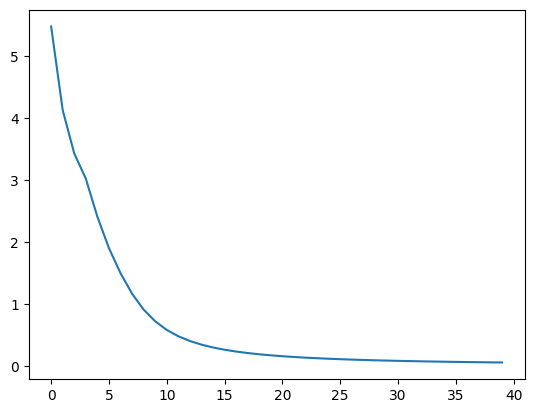

In [15]:
plt.plot(losses)

In [16]:
ypred

[Value(data=0.8906482716684159),
 Value(data=-0.8557953561422826),
 Value(data=-0.9087845930389793),
 Value(data=0.8730517668586932)]